<a href="https://colab.research.google.com/github/Tclack88/MountainProject/blob/master/rp_os_pyramids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redpoint/Onsight ladders

In [0]:
import pandas as pd
import numpy as np
from math import floor
from datetime import datetime as dt
import seaborn as sb
import matplotlib.pyplot as plt
sb.set(style='whitegrid')

In [0]:
# Get Grade for conversion (from Mountain Project's official grade converter)
grade_chart = pd.read_html("https://www.mountainproject.com/international-climbing-grades")
old_ropes = grade_chart[0].YDSUSA[:-1].to_list()
new_ropes = [0,0,0,0,1,2,3,4,5,6,7,7.4,8,8.4,8.8,9,9.4,9.8]+list(np.round(np.arange(10,16,.1),1))
ropes_convert = dict(zip(old_ropes,new_ropes))

In [0]:
# Supporting functions for clean and prep pipeline
def clean_grade(grade):
  grade = str(grade).split()[0]
  if grade[0] == '5':
    grade = ropes_convert[grade]
    return grade

def x_round(x):
  """ rounds down to nearest .25
  eg. x_round(11.49) = 11.25, x_round(11.51) = 11.5
  """
  if x >= 10:
    return floor(x*4)/4
  else: return x

trad_os.grade.apply(x_round).value_counts().sort_index(ascending=False)


# Rounding Key example:

# 10a, 10-, 10a/b  -> 10a
# 10b, 10          -> 10b
# 10b/c, 10c, 10+  -> 10c
# 10c/d, 10d       -> 10d


def grade_to_letter(grade):
  letter_map = {'.0':'a', '.25':'b', '.5':'c', '.75':'d'}
  letter_map_low = {'.0':'-', '.4':'', '.8':'+'}
  if grade >= 10:
    grade = str(grade)
    grade = grade[:2] + letter_map[grade[2:]]
    return grade
  else:
    grade = str(grade)
    grade = grade[:1] + letter_map_low[grade[1:]]
    return grade


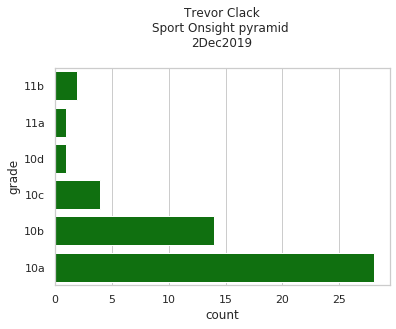

  grade  count
0   11b      2
1   11a      1
2   10d      1
3   10c      4
4   10b     14
5   10a     28


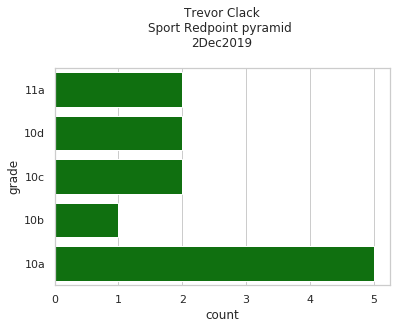

  grade  count
0   11a      2
1   10d      2
2   10c      2
3   10b      1
4   10a      5


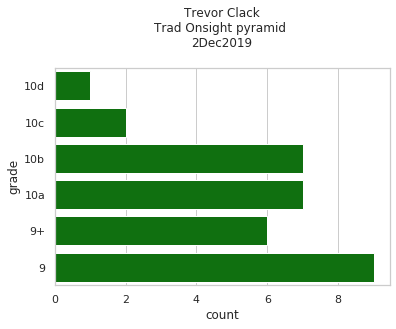

  grade  count
0   10d      1
1   10c      2
2   10b      7
3   10a      7
4    9+      6
5     9      9


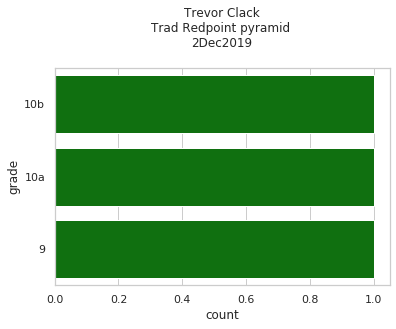

  grade  count
0   10b      1
1   10a      1
2     9      1


In [247]:
document = "https://www.mountainproject.com/user/109791883/trevor-clack/tick-export"
# document = "https://www.mountainproject.com/user/110296901/morgan-f/tick-export"
climber = document.split('/')[-2].replace('-',' ').title()
date = dt.now().strftime('%-d%b%Y')
data = pd.read_csv(document)
data = data[['Route', 'Rating', 'Style', 'Lead Style', 'Route Type']]
data = data.rename(columns = (dict(zip(data.columns,['route', 'grade', 'style', 'lead_style', 'type']))))
data.grade = data.grade.apply(clean_grade)
data = data[data['style'] == 'Lead']
# Split Trad and Sport data
trad = data[(data['type'] == 'Trad') | (data['type'] == 'Trad, Sport') | (data['type'] == 'Trad, Alpine') | (data['type'] == 'Trad, Aid')]
sport = data[(data['type'] == 'Sport') | (data['type'] == 'Sport, TR')]
trad_rp = trad[trad.lead_style == 'Redpoint']
trad_os = trad[trad.lead_style == 'Onsight']
sport_rp = sport[sport.lead_style == 'Redpoint']
sport_os = sport[sport.lead_style == 'Onsight']


styles = [sport_os, sport_rp, trad_os, trad_rp]

for style in styles:
  if not style.empty:
    title = f"{climber}\n{style.iloc[0]['type'].split(',')[0]} {style.iloc[0].lead_style} pyramid \n{date}\n"
    top_pyramid = style.grade.apply(x_round).value_counts().sort_index(ascending=False).iloc[:6].reset_index()
    top_pyramid.columns = ('grade','count')
    top_pyramid.grade = top_pyramid.grade.apply(grade_to_letter)
    sb.barplot(y='grade', x='count', data=top_pyramid, color='green')
    plt.title(title)
    plt.show()
    print(top_pyramid)